In [1]:
class Individual(object):

    def __init__(self):
        self.rank = None
        self.crowding_distance = None
        self.domination_count = None
        self.dominated_solutions = None
        self.features = None
        self.objectives = None

    def __eq__(self, other):
        if isinstance(self, other.__class__):
            return self.features == other.features
        return False

    def dominates(self, other_individual):
        and_condition = True
        or_condition = False
        for first, second in zip(self.objectives, other_individual.objectives):
            and_condition = and_condition and first <= second
            or_condition = or_condition or first < second
        return (and_condition and or_condition)
    
class Population:

    def __init__(self):
        self.population = []
        self.fronts = []

    def __len__(self):
        return len(self.population)

    def __iter__(self):
        return self.population.__iter__()

    def extend(self, new_individuals):
        self.population.extend(new_individuals)

    def append(self, new_individual):
        self.population.append(new_individual)

class Problem:

    def __init__(self, objectives, num_of_variables, variables_range, expand=True, same_range=False):
        self.num_of_objectives = len(objectives)
        self.num_of_variables = num_of_variables
        self.objectives = objectives
        self.expand = expand
        self.variables_range = []
        if same_range:
            for _ in range(num_of_variables):
                self.variables_range.append(variables_range[0])
        else:
            self.variables_range = variables_range

    def generate_individual(self):
        individual = Individual()
        individual.features = [random.uniform(*x) for x in self.variables_range]
        return individual

    def calculate_objectives(self, individual):
        if self.expand:
            individual.objectives = [f(*individual.features) for f in self.objectives]
        else:
            individual.objectives = [f(individual.features) for f in self.objectives]

class Evolution:

    def __init__(self, problem, num_of_generations=5000, num_of_individuals=100, num_of_tour_particips=2,
                 tournament_prob=0.9, crossover_param=2, mutation_param=5):
        self.utils = NSGA2Utils(problem, num_of_individuals, num_of_tour_particips, tournament_prob, crossover_param,
                                mutation_param)
        self.population = None
        self.num_of_generations = num_of_generations
        self.on_generation_finished = []
        self.num_of_individuals = num_of_individuals

    def evolve(self):
        self.population = self.utils.create_initial_population()
        self.utils.fast_nondominated_sort(self.population)
        for front in self.population.fronts:
            self.utils.calculate_crowding_distance(front)
        children = self.utils.create_children(self.population)
        returned_population = None
        for i in tqdm(range(self.num_of_generations)):
            self.population.extend(children)
            self.utils.fast_nondominated_sort(self.population)
            new_population = Population()
            front_num = 0
            while len(new_population) + len(self.population.fronts[front_num]) <= self.num_of_individuals:
                self.utils.calculate_crowding_distance(self.population.fronts[front_num])
                new_population.extend(self.population.fronts[front_num])
                front_num += 1
            self.utils.calculate_crowding_distance(self.population.fronts[front_num])
            self.population.fronts[front_num].sort(key=lambda individual: individual.crowding_distance, reverse=True)
            new_population.extend(self.population.fronts[front_num][0:self.num_of_individuals - len(new_population)])
            returned_population = self.population
            self.population = new_population
            self.utils.fast_nondominated_sort(self.population)
            for front in self.population.fronts:
                self.utils.calculate_crowding_distance(front)
            children = self.utils.create_children(self.population)
        return returned_population.fronts[0]

class NSGA2Utils:

    def __init__(self, problem, num_of_individuals=100,
                 num_of_tour_particips=2, tournament_prob=0.9, crossover_param=2, mutation_param=5):

        self.problem = problem
        self.num_of_individuals = num_of_individuals
        self.num_of_tour_particips = num_of_tour_particips
        self.tournament_prob = tournament_prob
        self.crossover_param = crossover_param
        self.mutation_param = mutation_param


    # Tạo quần thể ban đầu
    def create_initial_population(self):
        population = Population()
        for _ in range(self.num_of_individuals):
            individual = self.problem.generate_individual()
            self.problem.calculate_objectives(individual)
            population.append(individual)
        return population

    def fast_nondominated_sort(self, population):
        population.fronts = [[]]
        # Sắp xếp rank và đưa các individual vào front theo domination_count
        # Tìm các cá thể vào front 0
        for individual in population:
            individual.domination_count = 0
            individual.dominated_solutions = []
            for other_individual in population:
                if individual.dominates(other_individual):
                    individual.dominated_solutions.append(other_individual)
                elif other_individual.dominates(individual):
                    individual.domination_count += 1
            if individual.domination_count == 0:
                individual.rank = 0
                population.fronts[0].append(individual)
        i = 0
        while len(population.fronts[i]) > 0:
        # Phân loại các cá thể vào các front khác nhau
        # Vòng lặp while vẫn còn thực hiện khi front i còn chứa các cá thể
            temp = []
            for individual in population.fronts[i]:
                for other_individual in individual.dominated_solutions:
                    other_individual.domination_count -= 1
                    if other_individual.domination_count == 0:
                        other_individual.rank = i + 1
                        temp.append(other_individual)
            i = i + 1
            population.fronts.append(temp)

    def calculate_crowding_distance(self, front):
        if len(front) > 0:
            solutions_num = len(front)
            for individual in front:
                individual.crowding_distance = 0

            for m in range(len(front[0].objectives)):
                front.sort(key=lambda individual: individual.objectives[m])
                front[0].crowding_distance = 10 ** 9
                front[solutions_num - 1].crowding_distance = 10 ** 9
                m_values = [individual.objectives[m] for individual in front]
                scale = max(m_values) - min(m_values)
                if scale == 0: scale = 1
                for i in range(1, solutions_num - 1):
                    front[i].crowding_distance += (front[i + 1].objectives[m] - front[i - 1].objectives[m]) / scale

    def crowding_operator(self, individual, other_individual):
        if (individual.rank < other_individual.rank) or \
                ((individual.rank == other_individual.rank) and (
                        individual.crowding_distance > other_individual.crowding_distance)):
            return 1
        else:
            return -1

    def create_children(self, population):
        children = []
        while len(children) < len(population):
            parent1 = self.__tournament(population)
            parent2 = parent1
            while parent1 == parent2:
                parent2 = self.__tournament(population)
            child1, child2 = self.__crossover(parent1, parent2)
            self.__mutate(child1)
            self.__mutate(child2)
            self.problem.calculate_objectives(child1)
            self.problem.calculate_objectives(child2)
            children.append(child1)
            children.append(child2)

        return children

    def __crossover(self, individual1, individual2):
        child1 = self.problem.generate_individual()
        child2 = self.problem.generate_individual()
        num_of_features = len(child1.features)
        genes_indexes = range(num_of_features)
        for i in genes_indexes:
            beta = self.__get_beta()
            x1 = (individual1.features[i] + individual2.features[i]) / 2
            x2 = abs((individual1.features[i] - individual2.features[i]) / 2)
            child1.features[i] = x1 + beta * x2
            child2.features[i] = x1 - beta * x2
        return child1, child2

    def __get_beta(self):
        u = random.random()
        if u <= 0.5:
            return (2 * u) ** (1 / (self.crossover_param + 1))
        return (2 * (1 - u)) ** (-1 / (self.crossover_param + 1))

    def __mutate(self, child):
        num_of_features = len(child.features)
        for gene in range(num_of_features):
            u, delta = self.__get_delta()
            if u < 0.5:
                child.features[gene] += delta * (child.features[gene] - self.problem.variables_range[gene][0])
            else:
                child.features[gene] += delta * (self.problem.variables_range[gene][1] - child.features[gene])
            if child.features[gene] < self.problem.variables_range[gene][0]:
                child.features[gene] = self.problem.variables_range[gene][0]
            elif child.features[gene] > self.problem.variables_range[gene][1]:
                child.features[gene] = self.problem.variables_range[gene][1]

    def __get_delta(self):
        u = random.random()
        if u < 0.5:
            return u, (2 * u) ** (1 / (self.mutation_param + 1)) - 1
        return u, 1 - (2 * (1 - u)) ** (1 / (self.mutation_param + 1))

    def __tournament(self, population):
        participants = random.sample(population.population, self.num_of_tour_particips)
        best = None
        for participant in participants:
            if best is None or (
                    self.crowding_operator(participant, best) == 1 and self.__choose_with_prob(self.tournament_prob)):
                best = participant

        return best

    def __choose_with_prob(self, prob):
        if random.random() <= prob:
            return True
        return False

100%|██████████| 5000/5000 [05:57<00:00, 13.99it/s]


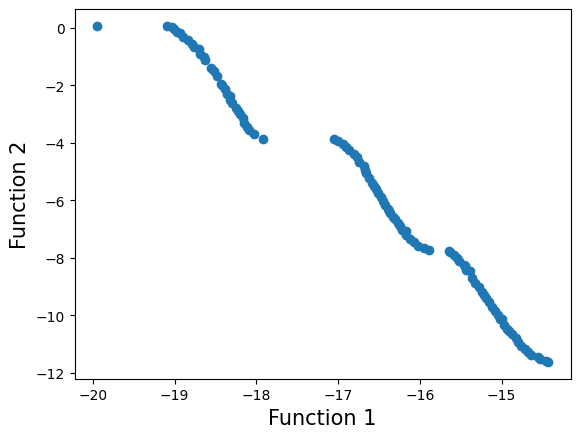

In [2]:
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm


def f1(x):
    s = 0
    for i in range(len(x) - 1):
        s += -10 * math.exp(-0.2 * math.sqrt(x[i] ** 2 + x[i + 1] ** 2))
    return s


def f2(x):
    s = 0
    for i in range(len(x)):
        s += abs(x[i]) ** 0.8 + 5 * math.sin(x[i] ** 3)
    return s


problem = Problem(num_of_variables=3, objectives=[f1, f2], variables_range=[(-5, 5)], same_range=True, expand=False)
evo = Evolution(problem, mutation_param=20)
func = [i.objectives for i in evo.evolve()]

function1 = [i[0] for i in func]
function2 = [i[1] for i in func]
plt.xlabel('Function 1', fontsize=15)
plt.ylabel('Function 2', fontsize=15)
plt.scatter(function1, function2)
plt.show()

100%|██████████| 5000/5000 [06:28<00:00, 12.87it/s]


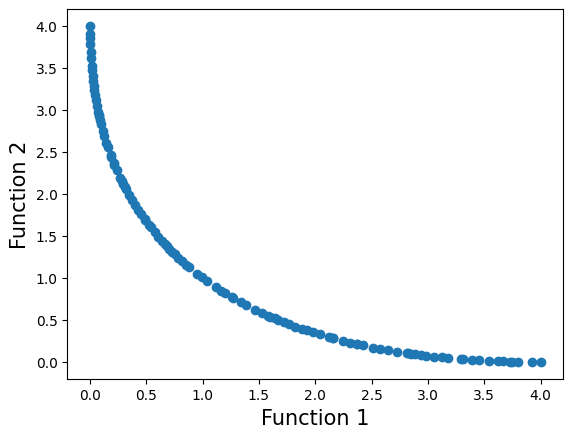

In [3]:
def f1(x):
    return x ** 2


def f2(x):
    return (x - 2) ** 2


problem = Problem(num_of_variables=1, objectives=[f1, f2], variables_range=[(-55, 55)])
evo = Evolution(problem)
evol = evo.evolve()
func = [i.objectives for i in evol]

function1 = [i[0] for i in func]
function2 = [i[1] for i in func]
plt.xlabel('Function 1', fontsize=15)
plt.ylabel('Function 2', fontsize=15)
plt.scatter(function1, function2)
plt.show()